## Task 3: Predictive Analysis - WIP
Consider the problem of predicting for each incident (considering the whole dataset for this task) the label which is a **binary variable** that indicates if in the incident there have been at least a killed person or not.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py
np.random.seed(42)



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import the datasets
df_incidents_cleaned = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5', key = 'df')

# Visualize data table
df_incidents_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131618 entries, 0 to 134578
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       131618 non-null  datetime64[ns]
 1   state                      131618 non-null  object        
 2   city_or_county             131618 non-null  object        
 3   latitude                   131618 non-null  float64       
 4   longitude                  131618 non-null  float64       
 5   congressional_district     131618 non-null  int64         
 6   participant_age_group1     131618 non-null  category      
 7   participant_gender1        131618 non-null  category      
 8   avg_age_participants       131618 non-null  int64         
 9   n_participants_child       131618 non-null  int64         
 10  n_participants_teen        131618 non-null  int64         
 11  n_females                  131618 non-null  int64   

In [3]:

df_incidents_dt = df_incidents_cleaned.copy()
#df_incidents_dt['n_participant_adult'] = (df_incidents_dt['n_participants'] - (df_incidents_dt['n_participants_child'] + df_incidents_dt['n_participants_teen'])).astype('int')


<AxesSubplot:title={'center':'Percentage of incidents with killed people'}, ylabel='isKilled'>

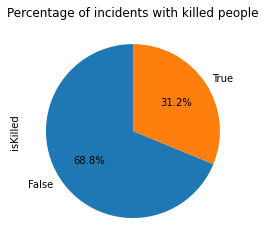

In [4]:
df_incidents_dt['isKilled'] = df_incidents_dt['ratio_killed'] > 0

#todo decide if mantain or drop the plot
df_incidents_dt['isKilled'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, title = 'Percentage of incidents with killed people')


In [5]:
coumns_not_to_drop_dt = [
                        'isKilled', 
                        'n_arrested', 
                        'n_females',
                        'avg_age_participants', 
                        'density_incident_state', 
                        'state', 
                        'n_injured',
                        'male_indicator'
                        'ratio_killed'
                        ]

# broke all if you add n_killed since is higly correlated : 0.94 <-- report consideration

all_columns_dt = df_incidents_dt.columns

columns_to_drop_dt = [x for x in all_columns_dt if x not in coumns_not_to_drop_dt]

df_incidents_dt.drop(columns_to_drop_dt, axis = 1, inplace = True)
df_incidents_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131618 entries, 0 to 134578
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   state                   131618 non-null  object 
 1   avg_age_participants    131618 non-null  int64  
 2   n_females               131618 non-null  int64  
 3   n_injured               131618 non-null  int64  
 4   n_arrested              131618 non-null  int64  
 5   density_incident_state  131618 non-null  float64
 6   isKilled                131618 non-null  bool   
dtypes: bool(1), float64(1), int64(4), object(1)
memory usage: 7.2+ MB


In [6]:

#make consideration about why we drop this columns and how they influence the models results
column_to_drop =  [
                   'longitude',
                   'latitude', 
                   'congressional_district',
                   'participant_age_group1',
                   'participant_gender1',
                   'incident_characteristics1',
                   'city_or_county',
                   'date',
                   'n_injured',
                   'party',
                   'candidatevotes',
                   'totalvotes',
                   'n_killed',
                   #'ratio_killed'
                   ]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

# Assuming df_incidents_cleaned is your original DataFrame

UMBALANCE_DATA =  False

if not UMBALANCE_DATA:

    # Select 100 samples where isKilled is True
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=30000, random_state=42)
    
    killed_samples_small = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=7000, random_state=42)
    # Select 100 samples where isKilled is False
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=30000, random_state=42)
    
    not_killed_samples_small = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=7000, random_state=42)
else:
    
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=500, random_state=42)
    
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=3000, random_state=42) 


# Concatenate the balanced samples into a new DataFrame
balanced_df = pd.concat([killed_samples, not_killed_samples])
balanced_df_small = pd.concat([killed_samples_small, not_killed_samples_small])
# Shuffle the rows in the new DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df_small = balanced_df_small.sample(frac=1, random_state=42).reset_index(drop=True)
# Display the balanced DataFrame
#print(balanced_df.head())  # You can replace this with your desired way of using the balanced dataset


In [8]:

target = balanced_df['isKilled']
target_small = balanced_df_small['isKilled']
df_dt = balanced_df.drop(['isKilled'], axis = 1)
df_dt_small = balanced_df_small.drop(['isKilled'], axis = 1)
df_dt = pd.get_dummies(df_dt)
df_dt_small = pd.get_dummies(df_dt_small)
df_dt_small.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_age_participants    14000 non-null  int64  
 1   n_females               14000 non-null  int64  
 2   n_injured               14000 non-null  int64  
 3   n_arrested              14000 non-null  int64  
 4   density_incident_state  14000 non-null  float64
 5   state_Alabama           14000 non-null  uint8  
 6   state_Alaska            14000 non-null  uint8  
 7   state_Arizona           14000 non-null  uint8  
 8   state_Arkansas          14000 non-null  uint8  
 9   state_California        14000 non-null  uint8  
 10  state_Colorado          14000 non-null  uint8  
 11  state_Connecticut       14000 non-null  uint8  
 12  state_Delaware          14000 non-null  uint8  
 13  state_Florida           14000 non-null  uint8  
 14  state_Georgia           14000 non-null

In [9]:

#X_train, X_test, y_train, y_test = train_test_split(df_dt, target, test_size=test_size, random_state=random_state)
train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)
train_set_small, test_set_small, train_label_small, test_label_small = train_test_split(df_dt_small, target_small, stratify = target_small, test_size=0.30)


### Todo
- Evaluate Normalization for each model as specific pre-processing (Y)
- Confusion matrix for each model (Y)
- ROC Curve for each model or general comparison between all models's ROC curve (Y)
- Decision tree grid search (Y)
    - Evaluate split based on GINI, Entropy and Misclassification error (Y)
    - Hunt’s algorithm for semi-optimal DT on large dataset (N)
    - Trees comparison by plot error vs number of nodes of DT in train and test (Y)
    - Evaluate complexity using Minimum Description Length (BOH)
- For NN, evaluate sampling strategies (even simplest one like stratified, over/under) (N)
- Ensemble methods (?)
    - AdaBoost (explained) (boh, se cè tempo)

# Regression

In [14]:
# import linear regression from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
# add grid search CV
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(random_state=0, max_iter=700, penalty='l2').fit(train_set, train_label)

clf.predict(test_set)

clf.predict_proba(test_set)

clf.score


# print scores
print('Accuracy score: ', accuracy_score(test_label, clf.predict(test_set)))
print('Precision score: ', precision_score(test_label, clf.predict(test_set)))
print('Recall score: ', recall_score(test_label, clf.predict(test_set)))

Accuracy score:  0.7525
Precision score:  0.7363986268594611
Recall score:  0.7865555555555556


# Decision Tree w grid search


In [16]:
#define a decision tree and fit it
# let's do GridSearchCV to find the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn import tree

parameters_grid_dt = {
        'max_depth': [15, 30, 50],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [4, 10, 20],
        'splitter': ['best', 'random'],
        'criterion': ['gini', 'entropy']
}

# grid search here
grid_search_dt = GridSearchCV(tree.DecisionTreeClassifier(), parameters_grid_dt, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)

best_model_dt = grid_search_dt.fit(train_set, train_label)

# print best model parameters
print('Best parameters for decision tree: ', best_model_dt.best_estimator_)

# test acc
print('Accuracy score: ', accuracy_score(test_label, best_model_dt.predict(test_set)))

'''
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy', 
                                splitter='best', 
                                max_depth=10, 
                                min_samples_split=60, 
                                min_samples_leaf=30)
dt = dt.fit(train_set, train_label)
'''

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

[CV 1/5; 3/360] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, splitter=best
[CV 2/5; 1/360] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 3/5; 1/360] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 5/5; 1/360] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 4/5; 2/360] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=random
[CV 3/5; 2/360] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=random
[CV 2/5; 3/360] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, splitter=best
[CV 2/5; 2/360] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=random
[CV 4/5; 1/360] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 5/5; 2/36

"\nfrom sklearn import tree\ndt = tree.DecisionTreeClassifier(criterion='entropy', \n                                splitter='best', \n                                max_depth=10, \n                                min_samples_split=60, \n                                min_samples_leaf=30)\ndt = dt.fit(train_set, train_label)\n"

[learning_curve] Training set sizes: [  336  1014  1693  2372  3051  3730  4409  5088  5766  6445  7124  7803
  8482  9161  9840 10518 11197 11876 12555 13234 13913 14592 15270 15949
 16628 17307 17986 18665 19344 20022 20701 21380 22059 22738 23417 24095
 24774 25453 26132 26811 27490 28169 28848 29526 30205 30884 31563 32242
 32921 33600]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.770, test=0.752) total time=   0.0s
[CV] END ..................., score=(train=0.774, test=0.635) total time=   0.0s
[CV] END ..................., score=(train=0.781, test=0.767) total time=   0.1s
[CV] END ..................., score=(train=0.781, test=0.765) total time=   0.1s
[CV] END ..................., score=(train=0.778, test=0.764) total time=   0.0s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  17 out of 250 | elapsed:    2.7s remaining:   37.1s


[CV] END ..................., score=(train=0.780, test=0.769) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.780, test=0.769) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.779, test=0.769) total time=   0.3s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.778, test=0.767) total time=   0.3s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.778, test=0.772) total time=   0.3s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  43 out of 250 | elapsed:    4.1s remaining:   20.0s


[CV] START .....................................................................
[CV] END ..................., score=(train=0.767, test=0.763) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.772, test=0.767) total time=   0.1s
[CV] END ..................., score=(train=0.774, test=0.763) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.773, test=0.769) total time=   0.9s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.775, test=0.764) total time=   0.1s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  69 out of 250 | elapsed:    4.8s remaining:   12.5s


[CV] START .....................................................................
[CV] END ..................., score=(train=0.779, test=0.769) total time=   0.2s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.779, test=0.764) total time=   0.3s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.779, test=0.770) total time=   0.2s
[CV] END ..................., score=(train=0.779, test=0.773) total time=   0.4s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.780, test=0.770) total time=   0.3s
[CV] END ..................., score=(train=0.781, test=0.769) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  95 out of 250 | elapsed:    6.2s remaining:   10.1s


[CV] START .....................................................................
[CV] END ..................., score=(train=0.778, test=0.758) total time=   0.1s
[CV] END ..................., score=(train=0.776, test=0.762) total time=   0.1s
[CV] START .....................................................................[CV] END ..................., score=(train=0.779, test=0.758) total time=   0.1s
[CV] END ..................., score=(train=0.780, test=0.769) total time=   0.8s

[CV] END ..................., score=(train=0.777, test=0.769) total time=   0.8s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.773, test=0.758) total time=   0.1s
[CV] START .....................................................................
[CV] START .................

[Parallel(n_jobs=-1)]: Done 121 out of 250 | elapsed:    6.9s remaining:    7.4s


[CV] END ..................., score=(train=0.782, test=0.764) total time=   0.3s
[CV] END ..................., score=(train=0.783, test=0.769) total time=   0.3s
[CV] END ..................., score=(train=0.782, test=0.760) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.781, test=0.765) total time=   0.3s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.780, test=0.763) total time=   0.4s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.782, test=0.764) total time=   0.3s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done 147 out of 250 | elapsed:    8.1s remaining:    5.7s


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.780, test=0.767) total time=   0.1s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.779, test=0.761) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.776, test=0.762) total time=   0.1s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.778, test=0.768) total time=   1.1s
[CV] END ..................., score=(train=0.781, test=0.763) total time=   0.1s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done 173 out of 250 | elapsed:    8.8s remaining:    3.9s


[CV] END ..................., score=(train=0.780, test=0.764) total time=   1.3s
[CV] END ..................., score=(train=0.783, test=0.766) total time=   0.5s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.781, test=0.768) total time=   0.2s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.779, test=0.768) total time=   0.3s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.781, test=0.767) total time=   0.3s
[CV] END ..................., score=(train=0.781, test=0.768) total time=   0.4s
[CV] END ..................., score=(train=0.781, test=0.765) total time=   0.4s
[CV] END ..................., score=(train=0.777, test=0.763) total time=   0.3s
[CV] START .....................................................................
[CV] START .................

[Parallel(n_jobs=-1)]: Done 199 out of 250 | elapsed:   10.0s remaining:    2.6s


[CV] END ..................., score=(train=0.779, test=0.750) total time=   0.1s
[CV] END ..................., score=(train=0.778, test=0.745) total time=   0.1s
[CV] END ..................., score=(train=0.778, test=0.748) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.782, test=0.752) total time=   0.1s
[CV] END ..................., score=(train=0.780, test=0.767) total time=   1.0s
[CV] END ..................., score=(train=0.780, test=0.754) total time=   0.1s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.782, test=0.766) total time=   0.7s
[CV] START .....................................................................
[CV] START .................

[Parallel(n_jobs=-1)]: Done 225 out of 250 | elapsed:   10.7s remaining:    1.2s


[CV] END ..................., score=(train=0.779, test=0.756) total time=   0.4s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.780, test=0.760) total time=   0.4s
[CV] END ..................., score=(train=0.778, test=0.755) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.780, test=0.756) total time=   0.4s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.778, test=0.768) total time=   1.5s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.781, test=0.759) total time=   0.5s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   12.0s finished


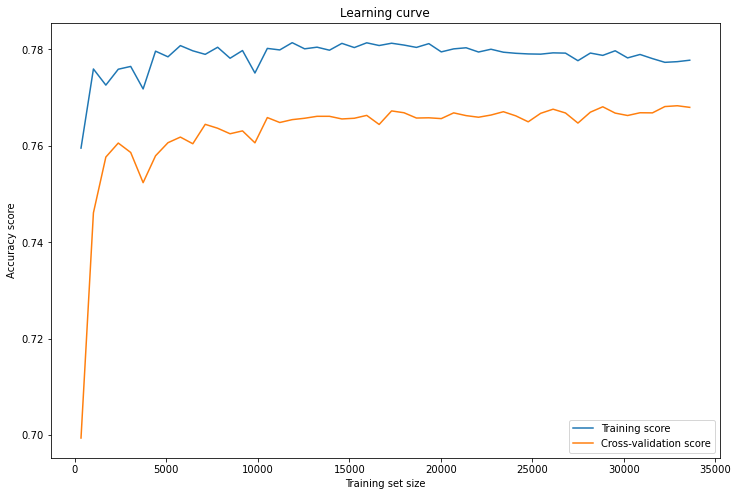

In [19]:
# check for overfitting in decision tree trough plot of the learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model_dt.best_estimator_,
                                                         train_set,
                                                         train_label,
                                                         cv=5,
                                                         scoring='accuracy',
                                                         n_jobs=-1,
                                                         train_sizes=np.linspace(0.01, 1.0, 50),
                                                         verbose=10)

# plot learning curve
plt.figure(figsize=(12,8))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Learning curve')
plt.xlabel('Training set size')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

In [ ]:
#visualize the actual decision tree obtained 
#import pydotplus 
##from IPython.display import Image  
#dot_data = tree.export_graphviz(dt, out_file=None, 
#                         feature_names=list(train_set.columns),  
#                         class_names=['<=50', '>50'],  
#                         filled=True, rounded=True)  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png())

In [17]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = best_model_dt.predict(train_set)
test_pred_dt = best_model_dt.predict(test_set)

In [18]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.7790714285714285
Accuracy test set  0.7687777777777778
Precision train set  0.7804739413772647
Recall train set  0.7790714285714285
F1 score train set  0.778794893973959
Support train set  (array([0.76064043, 0.80030746]), array([0.81442857, 0.74371429]), array([0.78661607, 0.77097371]), array([21000, 21000]))


In [ ]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [ ]:
report_scores(test_label, test_pred_dt)


# Neural Network: MLP

In [ ]:
import tensorflow as tf
import numpy as np
#train_set, test_set, train_label, test_label

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, 55)),
  tf.keras.layers.Dense(32, activation='sigmoid'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])



model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train = np.reshape(train_set.values, (len(train_set), 1, len(train_set.columns)))
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

In [ ]:
model.summary()

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
# Convert the test set to float32 if needed
x_test = np.reshape(test_set.values, (len(test_set), 1, len(test_set.columns)))
x_test = x_test.astype(np.float32)

# Then proceed with prediction
test_pred_nn = (model.predict(x_test) > 0.6).astype("int32")


In [ ]:
report_scores(test_label, test_pred_nn)

# Trying now models that can't scale really well with data size

## K-NN Classifier


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# use tqdm
import tqdm

k_list = [x for x in range(1, 25)]

knn_list = []
for k in tqdm.tqdm(k_list):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_set_small, train_label_small)
    knn_list.append(knn.score(test_set_small, test_label_small))
    
    # predictions
    prediction_train = knn.predict(train_set_small)
    prediction_test = knn.predict(test_set_small)
    
    #accuracy
    accuracy_train = metrics.accuracy_score(train_label_small, prediction_train)
    accuracy_test = metrics.accuracy_score(test_label_small, prediction_test)
    
    

In [ ]:
# print accuracy
print(accuracy_train)
print(accuracy_test)

In [ ]:
# plot results knn on x axis and accuracy on y axis
plt.plot(k_list, knn_list)
plt.xlabel('k')
plt.ylabel('Accuracy')
#track each k only
plt.xticks(k_list)
plt.title('Accuracy for different values of k')
# todo plot scores
plt.show()  

# SVM:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm

#train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)
# X_train, X_test, y_train, y_test = train_test_split(df_dt, target, test_size=test_size, random_state=random_state)

#x_train_reshaped = train_set.reshape(train_set.shape[0], -1)


svm_classifier = SVC(kernel='linear')

svm_classifier_rbf = SVC(kernel='rbf', C=1, gamma=0.1)

svm_classifier.fit(train_set_small, train_label_small)

svm_classifier_rbf.fit(train_set_small, train_label_small)

In [ ]:
def print_svm_scores(svm_classifier):
    print("Accuracy on training set: {:.3f}".format(svm_classifier.score(train_set_small, train_label_small)))
    print("Accuracy on test set: {:.3f}".format(svm_classifier.score(test_set_small, test_label_small)))
    
    # Make predictions
    y_pred = svm_classifier.predict(test_set_small)

    # Evaluate the model
    accuracy = accuracy_score(test_label_small, y_pred)
    report = classification_report(test_label_small, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)

In [ ]:
print_svm_scores(svm_classifier)

In [ ]:
print_svm_scores(svm_classifier_rbf)

# BE CAREFUL WE CAN MOVE THIS UP BECAUSE THIS DO NOT SUFFER OF PROBLEM WITH DATA SIZE

## Radom Forest

In [ ]:
# try random forest without grid search

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_set_scaled = scaler.fit_transform(train_set)
train_set_scaled = train_set

clf = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='entropy', n_estimators = 100)
clf_gini = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='gini', n_estimators = 100)

clf_gini.fit(train_set_scaled, train_label)
clf.fit(train_set_scaled, train_label)


# Scores for entropy and gini

In [ ]:
#metrics computed on the test set

from sklearn.metrics import classification_report

def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))
    
print("Scores for entropy\n\n")
    
y_pred_test = clf.predict(train_set_scaled)
report_scores(train_label, y_pred_test)

###### gini

print("Scores for gini\n\n")

y_pred_test = clf_gini.predict(train_set_scaled)
report_scores(train_label, y_pred_test)


Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# rand forest full ds
rf_classifier.fit(train_set, train_label)

# evaluate on test set full ds
test_predictions = rf_classifier.predict(test_set)

# Visualize metrics
print("Classification Report - Full df:")
print(classification_report(test_label, test_predictions))
print("Confusion Matrix - full df:")
print(confusion_matrix(test_label, test_predictions))
print("##############################################")

# train model on reduced df
rf_classifier.fit(train_set_small, train_label_small)

# evalutate on test set reduced df
test_predictions_small = rf_classifier.predict(test_set_small)

# Visualize metrics
print("\nClassification Report - reduced df:")
print(classification_report(test_label_small, test_predictions_small))
print("Confusion Matrix - reduced df:")
print(confusion_matrix(test_label_small, test_predictions_small))


results for both datasets are similar, but accuracy, precision, recall  and score are bit less with the reduced df due to the fact that has < #records